In [ ]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
import keras.optimizers 
from matplotlib import pyplot
import numpy as np
from math import sqrt

### Using the [fashion_mnist](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset

In [ ]:

(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


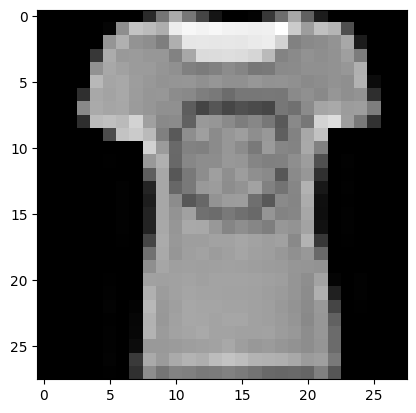

In [ ]:
pyplot.imshow(X_train[441], cmap='gray')

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [ ]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [ ]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'mnist_model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [ ]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [ ]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = tf.keras.optimizers.Adam(learning_rate =0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
discriminator = define_discriminator()

In [ ]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [ ]:
generator = define_generator(100)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = tf.keras.optimizers.Adam(learning_rate =0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
gan_model = define_gan(generator, discriminator)

In [ ]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)## This function saves the model for later use, as the training will take up some time
        return g_model

In [ ]:
latent_dim = 100
gan = train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

2/2 [==============================] - 0s 7ms/step
>1, dr[1.274,0.125], df[0.697,0.125], g[0.691,0.812]


In [ ]:
gan = g_model ## Loading the saved model if used later
latent_dim = 100
n_examples = 9
latent_points = generate_latent_points(latent_dim, n_examples)
X  = gan.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

## Lab 4
### Use this code to generate handwritten digits using the mnist dataset
#### The mnist dataset is available under keras.datasets

In [ ]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot

# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Normalize the input images
X_train = X_train.astype('float32')
X_train = (X_train - 127.5) / 127.5

# Expand the dimensions of the images to include the channel dimension
X_train = expand_dims(X_train, axis=-1)

# Define the discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    opt = Adam(learning_rate =0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define the generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

# Define the GAN model
def define_gan(g_model, d_model):
    # Make the discriminator not trainable when the GAN is trained
    d_model.trainable = False
    # Connect the generator output to the discriminator input
    gan_output = d_model(g_model.output)
    # Define the GAN model
    model = Model(g_model.input, gan_output)
    # Compile the GAN model
    opt = Adam(learning_rate =0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Generate real samples for the discriminator
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    # Generate class labels for real samples (1)
    y = ones((n_samples, 1))
    return X, y

# Generate fake samples for the discriminator
def generate_fake_samples(generator, latent_dim, n_samples):
    # Generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # Generate fake samples
    X = generator.predict(x_input)
    # Generate class labels for fake samples (0)
    y = zeros((n_samples, 1))
    return X, y

def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=1, n_batch=2, n_eval=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # Train discriminator on real samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = discriminator.train_on_batch(X_real, y_real)
            # Train discriminator on fake samples
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            d_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)
            # Train generator via gan
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan.train_on_batch(X_gan, y_gan)
            # Summarize loss on this batch
        print(f"{i+1}/{n_steps}, d1={d_loss1:.3f}, d2={d_loss2:.3f}, g={g_loss:.3f}")
        # Evaluate every n_eval epochs
        if (i+1) % n_eval == 0:
            # Save and display generated images
            X_fake, _ = generate_fake_samples(generator, latent_dim, 25)
            X_fake = (X_fake + 1) / 2.0
            for k in range(25):
                pyplot.subplot(5, 5, k+1)
                pyplot.imshow(X_fake[k, :, :, 0], cmap='gray_r')
                pyplot.axis('off')
            pyplot.show()
            # Save the model weights
            gan.save('generator_model_%03d.h5' % (i+1))


In [ ]:
def create_gan(generator, discriminator):
    # Make weights in the discriminator not trainable
    discriminator.trainable = False
    # Connect generator and discriminator
    gan_input = Input(shape=(latent_dim,))
    generated_images = generator(gan_input)
    gan_output = discriminator(generated_images)
    gan_model = Model(inputs=gan_input, outputs=gan_output)
    gan_model.compile(loss='binary_crossentropy', optimizer=Adam(lr =0.0002, beta_1=0.5))
    return gan_model


In [ ]:
# define the discriminator model
d_model = define_discriminator()

# compile the discriminator model
d_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate =0.0002, beta_1=0.5))

# define the generator model
g_model = define_generator(latent_dim)

# define the GAN model
gan_model = define_gan(g_model, d_model)

# compile the GAN model
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate =0.0002, beta_1=0.5))



In [ ]:
# Train the GAN on MNIST
latent_dim = 100
gan_model = create_gan(generator, discriminator)
train(generator, discriminator, gan_model, X_train, latent_dim)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step


KeyboardInterrupt: ignored

In [ ]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.25))
	model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.25))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate =0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate =0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=40, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 0s 5ms/step
>1, 1/234, d=0.698, g=0.709
4/4 [==============================] - 0s 5ms/step
>1, 2/234, d=0.689, g=0.723
4/4 [==============================] - 0s 5ms/step
>1, 3/234, d=0.680, g=0.742
4/4 [==============================] - 0s 4ms/step
>1, 4/234, d=0.673, g=0.757
4/4 [==============================] - 0s 4ms/step
>1, 5/234, d=0.666, g=0.772
4/4 [==============================] - 0s 3ms/step
>1, 6/234, d=0.659, g=0.786
4/4 [==============================] - 0s 4ms/step
>1, 7/234, d=0.657, g=0.801
4/4 [==============================] - 0s 3ms/step
>1, 8/234, d=0.648, g=0.809
4/4 [==============================] - 0s 4ms/step
>1, 9/234, d=0.646, g=0.815
4/4 [==============================] - 0s 3ms/step
>1, 10/234, d=0.642, g=0.818
4/4 [==============================] - 0s 4ms/step
>1, 11/234, d=0.643, g=0.813
4/4 [==============================] - 0s 4ms/step
>1, 12/234, d=0.641, g=0.799
4/4 [==============================] - 0s 3ms/ste

4/4 [==============================] - 0s 5ms/step
>11, 1/234, d=0.681, g=0.722
4/4 [==============================] - 0s 8ms/step
>11, 2/234, d=0.671, g=0.723
4/4 [==============================] - 0s 4ms/step
>11, 3/234, d=0.675, g=0.739
4/4 [==============================] - 0s 4ms/step
>11, 4/234, d=0.674, g=0.730
4/4 [==============================] - 0s 4ms/step
>11, 5/234, d=0.672, g=0.726
4/4 [==============================] - 0s 4ms/step
>11, 6/234, d=0.677, g=0.725
4/4 [==============================] - 0s 5ms/step
>11, 7/234, d=0.674, g=0.727
4/4 [==============================] - 0s 4ms/step
>11, 8/234, d=0.676, g=0.715
4/4 [==============================] - 0s 4ms/step
>11, 9/234, d=0.682, g=0.710
4/4 [==============================] - 0s 3ms/step
>11, 10/234, d=0.681, g=0.699
4/4 [==============================] - 0s 5ms/step
>11, 11/234, d=0.678, g=0.706
4/4 [==============================] - 0s 5ms/step
>11, 12/234, d=0.689, g=0.712
4/4 [==============================] 

4/4 [==============================] - 0s 8ms/step
>21, 1/234, d=0.685, g=0.716
4/4 [==============================] - 0s 6ms/step
>21, 2/234, d=0.687, g=0.703
4/4 [==============================] - 0s 5ms/step
>21, 3/234, d=0.685, g=0.682
4/4 [==============================] - 0s 4ms/step
>21, 4/234, d=0.689, g=0.694
4/4 [==============================] - 0s 4ms/step
>21, 5/234, d=0.686, g=0.733
4/4 [==============================] - 0s 4ms/step
>21, 6/234, d=0.678, g=0.727
4/4 [==============================] - 0s 4ms/step
>21, 7/234, d=0.680, g=0.682
4/4 [==============================] - 0s 4ms/step
>21, 8/234, d=0.685, g=0.671
4/4 [==============================] - 0s 5ms/step
>21, 9/234, d=0.693, g=0.716
4/4 [==============================] - 0s 4ms/step
>21, 10/234, d=0.682, g=0.758
4/4 [==============================] - 0s 4ms/step
>21, 11/234, d=0.676, g=0.757
4/4 [==============================] - 0s 3ms/step
>21, 12/234, d=0.690, g=0.671
4/4 [==============================] 

4/4 [==============================] - 0s 9ms/step
>31, 1/234, d=0.684, g=0.708
4/4 [==============================] - 0s 6ms/step
>31, 2/234, d=0.676, g=0.709
4/4 [==============================] - 0s 7ms/step
>31, 3/234, d=0.683, g=0.717
4/4 [==============================] - 0s 5ms/step
>31, 4/234, d=0.672, g=0.701
4/4 [==============================] - 0s 6ms/step
>31, 5/234, d=0.679, g=0.713
4/4 [==============================] - 0s 5ms/step
>31, 6/234, d=0.688, g=0.747
4/4 [==============================] - 0s 5ms/step
>31, 7/234, d=0.685, g=0.750
4/4 [==============================] - 0s 6ms/step
>31, 8/234, d=0.673, g=0.704
4/4 [==============================] - 0s 4ms/step
>31, 9/234, d=0.678, g=0.690
4/4 [==============================] - 0s 5ms/step
>31, 10/234, d=0.680, g=0.725
4/4 [==============================] - 0s 5ms/step
>31, 11/234, d=0.699, g=0.713
4/4 [==============================] - 0s 5ms/step
>31, 12/234, d=0.691, g=0.694
4/4 [==============================] 

In [ ]:
filename = 'generator_model_%03d.h5' % (epoch + 1)
g_model.save(filename)



4/4 [==============================] - 0s 6ms/step


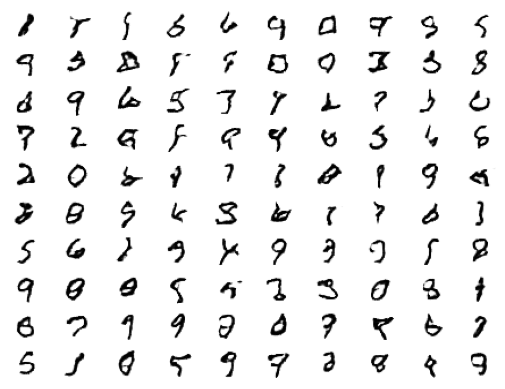

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = g_model
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 10)

In [ ]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot

# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Normalize the input images
X_train = X_train.astype('float32')
X_train = (X_train - 127.5) / 127.5

# Expand the dimensions of the images to include the channel dimension
X_train = expand_dims(X_train, axis=-1)

# Define the discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define the generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

# Define the GAN model
def define_gan(g_model, d_model):
    # Make the discriminator not trainable when the GAN is trained
    d_model.trainable = False
    # Connect the generator output to the discriminator input
    gan_output = d_model(g_model.output)
    # Define the GAN model
    model = Model(g_model.input, gan_output)
    # Compile the GAN model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Generate real samples for the discriminator
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    # Generate class labels for real samples (1)
    y = ones((n_samples, 1))
    return X, y

# Generate fake samples for the discriminator
def generate_fake_samples(generator, latent_dim, n_samples):
    # Generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # Generate fake samples
    X = generator.predict(x_input)
    # Generate class labels for fake samples (0)
    y = zeros((n_samples, 1))
    return X, y

# Train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=40, n_batch=256):
    # Determine the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # Determine the number of training iterations
    n_steps = bat_per_epo
    # Determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # Manually enumerate epochs
    for i in range(n_steps):
        # Get randomly selected real samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # Update the discriminator with real samples
        d_loss1, _ = d_model.train_on_batch(X_real, y_real)
        # Generate fake samples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # Update the discriminator with fake samples
        d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
        # Generate points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # Create inverted labels for the fake samples, so they are labeled as real
        y_gan = ones((n_batch, 1))
        # Update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # Summarize loss on this batch
        print(f"{i+1}/{n_steps}, d1={d_loss1:.3f}, d2={d_loss2:.3f}, g={g_loss:.3f}")


In [ ]:
# Compile the discriminator
d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
# Compile the GAN
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))


In [ ]:
# Train the GAN on MNIST
latent_dim = 100
gan_model = create_gan(generator, discriminator)
train(generator, discriminator, gan_model, X_train, latent_dim)


4/4 [==============================] - 0s 2ms/step
1/234, d1=0.631, d2=0.775, g=0.630
4/4 [==============================] - 0s 2ms/step
2/234, d1=0.640, d2=0.778, g=0.628
4/4 [==============================] - 0s 2ms/step
3/234, d1=0.641, d2=0.773, g=0.631
4/4 [==============================] - 0s 3ms/step
4/234, d1=0.629, d2=0.763, g=0.625
4/4 [==============================] - 0s 2ms/step
5/234, d1=0.632, d2=0.775, g=0.632
4/4 [==============================] - 0s 2ms/step
6/234, d1=0.633, d2=0.773, g=0.645
4/4 [==============================] - 0s 2ms/step
7/234, d1=0.656, d2=0.760, g=0.643
4/4 [==============================] - 0s 2ms/step
8/234, d1=0.654, d2=0.764, g=0.643
4/4 [==============================] - 0s 2ms/step
9/234, d1=0.642, d2=0.766, g=0.652
4/4 [==============================] - 0s 2ms/step
10/234, d1=0.664, d2=0.764, g=0.643
4/4 [==============================] - 0s 2ms/step
11/234, d1=0.661, d2=0.761, g=0.647
4/4 [==============================] - 0s 5ms/step
1

1/1 [==============================] - 0s 78ms/step


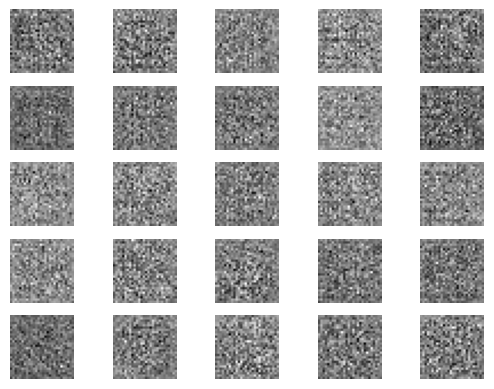

In [ ]:
# Generate images from the generator
latent_points = generate_latent_points(latent_dim, 25)
generated_images = g_model.predict(latent_points)

# Rescale the images from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0

# Plot the generated images
for i in range(25):
    # Define subplot
    pyplot.subplot(5, 5, 1 + i)
    # Turn off axis labels
    pyplot.axis('off')
    # Plot single image
    pyplot.imshow(generated_images[i, :, :, 0], cmap='gray_r')

# Save the plot to file
pyplot.savefig('generated_images.png')
# Show the plot
pyplot.show()
